In [1]:
#librerias
import pandas as pd
import numpy as np
import pyodbc

import matplotlib.pyplot as plot
import seaborn as sns


from datetime import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')


**1. Selección de datos**

In [2]:
#Conexión database
conn = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}',
                      SERVER='dblatinkadwh.database.windows.net',
                      DATABASE='DWH_LaTinka',
                      UID='sandra.sanchez',
                      PWD='Latinka01*')
print(conn)


In [3]:
#No se tomó en cuenta los datos con target null
q0 = """SELECT *
        FROM [EDS].[TABLON_MODELO_FUGA_CLIENTE]
        WHERE FLG_FELICIDAD IS NOT NULL AND CODMES=202212"""
df = pd.read_sql_query(q0,conn)

#Cerrar conexión 
conn.close()

In [5]:
df.head(3)

,CODMES,ID_CLIENTE,VENTA_NETA_CASINO,VENTA_NETA_DEPORTE_VIRTUAL,VENTA_NETA_GANA_DIARIO,VENTA_NETA_GANAGOL,VENTA_NETA_KABALA,VENTA_NETA_KINELO,VENTA_NETA_RASPAYA,VENTA_NETA_TE_APUESTO,...,FECHA_ALTA_SISTEMA,FECHA_NACIMIENTO,PRODUCTO_PRINCIPAL,ESTADO_CLIENTE,FRECUENCY,MONETARY,RECENCY,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,FLG_FELICIDAD
0,202212,804013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,2019-04-27,1985-07-08,Te Apuesto,2. Recurrente,4. Habitual,5. Muy Bajo,1. Activo,2019-06-14,2023-04-15,No Feliz
1,202212,2113627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,...,2022-12-03,2003-09-09,Te Apuesto,4. No Activo,5. Ocasional,5. Muy Bajo,3. Dormido 2,2022-12-03,2023-01-05,Feliz
2,202212,1741376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0,...,2022-06-05,1995-07-16,Te Apuesto,2. Recurrente,3. Frecuente,4. Bajo,1. Activo,2022-06-05,2023-04-19,Feliz


**2. Procesamiento**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96223 entries, 0 to 96222
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CODMES                      96223 non-null  int64  
 1   ID_CLIENTE                  96223 non-null  int64  
 2   VENTA_NETA_CASINO           96223 non-null  float64
 3   VENTA_NETA_DEPORTE_VIRTUAL  96223 non-null  float64
 4   VENTA_NETA_GANA_DIARIO      96223 non-null  float64
 5   VENTA_NETA_GANAGOL          96223 non-null  float64
 6   VENTA_NETA_KABALA           96223 non-null  float64
 7   VENTA_NETA_KINELO           96223 non-null  float64
 8   VENTA_NETA_RASPAYA          96223 non-null  float64
 9   VENTA_NETA_TE_APUESTO       96223 non-null  float64
 10  VENTA_NETA_TINKA            96223 non-null  float64
 11  NUM_VISITA                  96223 non-null  int64  
 12  TOTAL_RECARGA               96223 non-null  float64
 13  TOTAL_TRANSACCION_RECARGA   962

In [7]:
#Conversion de String a datetime
df['FECHA_ALTA_SISTEMA'] = pd.to_datetime(df['FECHA_ALTA_SISTEMA'], format = "%Y-%m-%d")
df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], format = "%Y-%m-%d")
df['FECHA_PRIMERA_ACCION'] = pd.to_datetime(df['FECHA_PRIMERA_ACCION'], format="%Y-%m-%d")
df['FECHA_ULTIMA_ACCION'] = pd.to_datetime(df['FECHA_ULTIMA_ACCION'], format = "%Y-%m-%d")

In [8]:
df.isnull().sum()

CODMES                         0
ID_CLIENTE                     0
VENTA_NETA_CASINO              0
VENTA_NETA_DEPORTE_VIRTUAL     0
VENTA_NETA_GANA_DIARIO         0
VENTA_NETA_GANAGOL             0
VENTA_NETA_KABALA              0
VENTA_NETA_KINELO              0
VENTA_NETA_RASPAYA             0
VENTA_NETA_TE_APUESTO          0
VENTA_NETA_TINKA               0
NUM_VISITA                     0
TOTAL_RECARGA                  0
TOTAL_TRANSACCION_RECARGA      0
FECHA_ALTA_SISTEMA             0
FECHA_NACIMIENTO              24
PRODUCTO_PRINCIPAL             0
ESTADO_CLIENTE                 0
FRECUENCY                      0
MONETARY                       0
RECENCY                        0
FECHA_PRIMERA_ACCION           0
FECHA_ULTIMA_ACCION            0
FLG_FELICIDAD                  0
dtype: int64

In [9]:
#Eliminar filas con valores nulos 
df.dropna(inplace=True)

In [10]:
#Calular la Edad
df['EDAD'] = ((datetime.now() -df['FECHA_NACIMIENTO']).dt.days / 365).round(0).astype("int64")

In [11]:
df['DIAS_CON'] = (df['FECHA_ULTIMA_ACCION']-df['FECHA_PRIMERA_ACCION']).dt.days


In [12]:
#Reclass variables
df['PRODUCTO_PRINCIPAL'] = np.where(df['PRODUCTO_PRINCIPAL'] == 'Tinka', 1, 
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Kabala', 2,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Te Apuesto', 3,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Casino', 4,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Gana Diario', 5,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Raspaya', 6,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Kinelo', 7,
                                            np.where(df['PRODUCTO_PRINCIPAL'] == 'Ganagol', 8,9))))))))

df['ESTADO_CLIENTE'] = np.where(df['ESTADO_CLIENTE'] == '4. No Activo',4,
                                        np.where(df['ESTADO_CLIENTE'] == '2. Recurrente',2,
                                        np.where(df['ESTADO_CLIENTE'] == '3. Esporadico',3,1)))

df['FRECUENCY'] = np.where(df['FRECUENCY'] == '1. Permanente',1,
                                   np.where(df['FRECUENCY'] == '1. Permanente',1,
                                   np.where(df['FRECUENCY'] == '2. Intensivo',2,
                                   np.where(df['FRECUENCY'] == '3. Frecuente',3,
                                   np.where(df['FRECUENCY'] == '4. Habitual',4,5)))))

df['MONETARY'] = np.where(df['MONETARY'] == '1. Muy Alto',1,
                          np.where(df['MONETARY'] == '2. Alto', 2,
                          np.where(df['MONETARY'] == '3. Medio', 3,
                          np.where(df['MONETARY'] == '4. Bajo', 4,5))))

df['RECENCY'] = np.where(df['RECENCY'] == '1. Activo', 1,
                          np.where(df['RECENCY'] == '2. Dormido 1',1,
                          np.where(df['RECENCY'] == '3. Dormido 2',1,
                          np.where(df['RECENCY'] == '4. Perdido',0,1))))

df['FLG_FELICIDAD'] = np.where(df['FLG_FELICIDAD'] == 'No Feliz',0,1)

In [13]:
df.set_index('ID_CLIENTE',inplace=True)

In [14]:
df.head()

,CODMES,VENTA_NETA_CASINO,VENTA_NETA_DEPORTE_VIRTUAL,VENTA_NETA_GANA_DIARIO,VENTA_NETA_GANAGOL,VENTA_NETA_KABALA,VENTA_NETA_KINELO,VENTA_NETA_RASPAYA,VENTA_NETA_TE_APUESTO,VENTA_NETA_TINKA,...,PRODUCTO_PRINCIPAL,ESTADO_CLIENTE,FRECUENCY,MONETARY,RECENCY,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,FLG_FELICIDAD,EDAD,DIAS_CON
ID_CLIENTE,,,,,,,,,,,,,,,,,,,,,
804013,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,...,3,2,4,5,1,2019-06-14,2023-04-15,0,38,1401
2113627,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,...,3,4,5,5,1,2022-12-03,2023-01-05,1,20,33
1741376,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,...,3,2,3,4,1,2022-06-05,2023-04-19,1,28,318
2124731,202212,605.0,0.0,0.0,0.0,0.0,0.0,0.0,494.0,0.0,...,4,4,4,4,1,2022-12-06,2023-01-06,1,49,31
1148425,202212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,...,3,4,3,5,1,2020-09-16,2023-03-31,0,25,926


In [15]:
df2 = df.loc[:,['TOTAL_RECARGA', 'TOTAL_TRANSACCION_RECARGA','PRODUCTO_PRINCIPAL', 'FRECUENCY', 'MONETARY', 'RECENCY', 'EDAD', 'DIAS_CON', 'FLG_FELICIDAD']]

In [16]:
df2.groupby('RECENCY')['RECENCY'].count()

RECENCY
0    33156
1    63043
Name: RECENCY, dtype: int64

## División en objetivo y variables

In [17]:
X = df2.drop(['RECENCY'], axis=1)
Y = df2['RECENCY']

In [18]:
X.head(3)

,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,EDAD,DIAS_CON,FLG_FELICIDAD
ID_CLIENTE,,,,,,,,
804013,20.0,1,3,4,5,38,1401,0
2113627,35.0,2,3,5,5,20,33,1
1741376,50.0,1,3,3,4,28,318,1


In [19]:
Y.unique()

array([1, 0])

## Usando UBML

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=29)
print(len(X_train))
print(len(X_test))

76959
19240


In [80]:
from ubml.train_test import classification_train_test
metrics_performance, best_model = classification_train_test(x_train=X_train, x_test=X_test, y_train=Y_train, y_test=Y_test)
print(best_model)
metrics_performance


Random Forest Classifier


,accuracy score train,accuracy score test,f1 score train,f1 score test,recall score train,recall score test,jaccard score train,jaccard score test,precision score train,precision score test
Logistic Regression,0.744,0.747,0.807,0.809,0.817,0.821,0.676,0.680,0.797,0.798
KNN Classifier,0.878,0.842,0.910,0.884,0.945,0.918,0.836,0.792,0.878,0.853
SVM Classifier,0.743,0.749,0.801,0.804,0.788,0.790,0.668,0.673,0.815,0.819
Naive Bayes Classifier,0.578,0.584,0.548,0.553,0.390,0.394,0.378,0.382,0.921,0.927
Decision Tree Classifier,0.999,0.815,0.999,0.857,0.998,0.853,0.998,0.751,1.000,0.862
Random Forest Classifier,0.999,0.854,0.999,0.893,0.999,0.927,0.998,0.806,0.999,0.861


In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, Y_train)


LogisticRegression()

In [22]:
test_data = lr.predict(X_test)
print(test_data)

[1 1 1 ... 1 1 0]


In [23]:
prob_test_data = lr.predict_proba(X_test)
print(prob_test_data)

[[5.42692627e-02 9.45730737e-01]
 [3.05764037e-01 6.94235963e-01]
 [2.82759266e-03 9.97172407e-01]
 ...
 [3.13990937e-04 9.99686009e-01]
 [2.74600308e-01 7.25399692e-01]
 [6.84740020e-01 3.15259980e-01]]


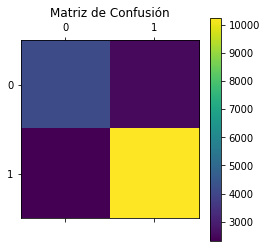

In [25]:
#Matriz de confusion 
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(Y_test, test_data)
pl.matshow(cm)
pl.title('Matriz de Confusión')
pl.colorbar()
pl.show()


In [28]:
cm

array([[ 4134,  2534],
       [ 2324, 10248]], dtype=int64)

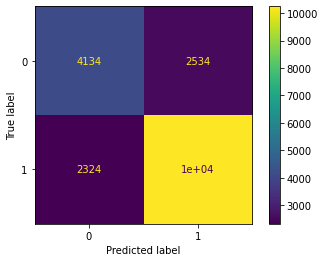

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()


Cargando y procesnado los datos de Test 2023

In [91]:
#Conexión database
conn1 = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}',
                      SERVER='dblatinkadwh.database.windows.net',
                      DATABASE='DWH_LaTinka',
                      UID='sandra.sanchez',
                      PWD='Latinka01*')

In [92]:
# No se tomó en cuenta los datos con target null
q1 = """SELECT *
        FROM [EDS].[TABLON_MODELO_FUGA_CLIENTE]
        WHERE FLG_FELICIDAD IS NOT NULL AND CODMES=202301"""
df2 = pd.read_sql_query(q1, conn1)

#Cerrar conexión
conn1.close()


In [93]:
df2.head(4)

,CODMES,ID_CLIENTE,VENTA_NETA_CASINO,VENTA_NETA_DEPORTE_VIRTUAL,VENTA_NETA_GANA_DIARIO,VENTA_NETA_GANAGOL,VENTA_NETA_KABALA,VENTA_NETA_KINELO,VENTA_NETA_RASPAYA,VENTA_NETA_TE_APUESTO,...,FECHA_ALTA_SISTEMA,FECHA_NACIMIENTO,PRODUCTO_PRINCIPAL,ESTADO_CLIENTE,FRECUENCY,MONETARY,RECENCY,FECHA_PRIMERA_ACCION,FECHA_ULTIMA_ACCION,FLG_FELICIDAD
0,202301,773862,0.0,0.0,2.0,0.0,4.0,7.0,4.0,0.0,...,2019-03-20,1993-11-20,Kinelo,3. Esporadico,5. Ocasional,5. Muy Bajo,3. Dormido 2,2023-01-12,2023-01-14,No Feliz
1,202301,1168116,0.0,32.0,0.0,0.0,0.0,0.0,0.0,169.0,...,2020-10-08,1999-03-04,Te Apuesto,4. No Activo,3. Frecuente,5. Muy Bajo,2. Dormido 1,2022-12-10,2023-03-25,No Feliz
2,202301,2393968,0.0,301.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2023-01-13,1985-10-07,Deporte Virtual,3. Esporadico,5. Ocasional,4. Bajo,3. Dormido 2,2023-01-15,2023-01-15,No Feliz
3,202301,1130063,0.0,0.0,0.0,0.0,0.0,1.0,2.5,0.0,...,2020-09-06,1987-02-04,Tinka,3. Esporadico,5. Ocasional,5. Muy Bajo,2. Dormido 1,2023-01-20,2023-03-05,No Feliz


In [94]:
#Conversion de String a datetime
df2['FECHA_ALTA_SISTEMA'] = pd.to_datetime(df2['FECHA_ALTA_SISTEMA'], format = "%Y-%m-%d")
df2['FECHA_NACIMIENTO'] = pd.to_datetime(df2['FECHA_NACIMIENTO'], format = "%Y-%m-%d")
df2['FECHA_PRIMERA_ACCION'] = pd.to_datetime(df2['FECHA_PRIMERA_ACCION'], format="%Y-%m-%d")
df2['FECHA_ULTIMA_ACCION'] = pd.to_datetime(df2['FECHA_ULTIMA_ACCION'], format = "%Y-%m-%d")

In [95]:
# Eliminar filas con valores nulos
df2.dropna(inplace=True)


# Calular la Edad
df2['EDAD'] = ((datetime.now() - df2['FECHA_NACIMIENTO']
               ).dt.days / 365).round(0).astype("int64")

df2['DIAS_CON'] = (df2['FECHA_ULTIMA_ACCION']-df2['FECHA_PRIMERA_ACCION']).dt.days


In [96]:

# Reclass variables
df2['PRODUCTO_PRINCIPAL'] = np.where(df2['PRODUCTO_PRINCIPAL'] == 'Tinka', 1,
                                    np.where(df2['PRODUCTO_PRINCIPAL'] == 'Kabala', 2,
                                             np.where(df2['PRODUCTO_PRINCIPAL'] == 'Te Apuesto', 3,
                                                      np.where(df2['PRODUCTO_PRINCIPAL'] == 'Casino', 4,
                                                               np.where(df2['PRODUCTO_PRINCIPAL'] == 'Gana Diario', 5,
                                                                        np.where(df2['PRODUCTO_PRINCIPAL'] == 'Raspaya', 6,
                                                                                 np.where(df2['PRODUCTO_PRINCIPAL'] == 'Kinelo', 7,
                                                                                          np.where(df2['PRODUCTO_PRINCIPAL'] == 'Ganagol', 8, 9))))))))

df2['ESTADO_CLIENTE'] = np.where(df2['ESTADO_CLIENTE'] == '4. No Activo', 4,
                                np.where(df2['ESTADO_CLIENTE'] == '2. Recurrente', 2,
                                         np.where(df2['ESTADO_CLIENTE'] == '3. Esporadico', 3, 1)))

df2['FRECUENCY'] = np.where(df2['FRECUENCY'] == '1. Permanente', 1,
                           np.where(df2['FRECUENCY'] == '1. Permanente', 1,
                                    np.where(df2['FRECUENCY'] == '2. Intensivo', 2,
                                             np.where(df2['FRECUENCY'] == '3. Frecuente', 3,
                                                      np.where(df2['FRECUENCY'] == '4. Habitual', 4, 5)))))

df2['MONETARY'] = np.where(df2['MONETARY'] == '1. Muy Alto', 1,
                          np.where(df2['MONETARY'] == '2. Alto', 2,
                          np.where(df2['MONETARY'] == '3. Medio', 3,
                                   np.where(df2['MONETARY'] == '4. Bajo', 4, 5))))

df2['RECENCY'] = np.where(df2['RECENCY'] == '1. Activo', 1,
                         np.where(df2['RECENCY'] == '2. Dormido 1', 1,
                                  np.where(df2['RECENCY'] == '3. Dormido 2', 1,
                                           np.where(df2['RECENCY'] == '4. Perdido', 0, 1))))

df2['FLG_FELICIDAD'] = np.where(df2['FLG_FELICIDAD'] == 'No Feliz', 0, 1)


In [97]:
df3 = df2.loc[:,['ID_CLIENTE','TOTAL_RECARGA', 'TOTAL_TRANSACCION_RECARGA','PRODUCTO_PRINCIPAL', 'FRECUENCY', 'MONETARY', 'RECENCY', 'EDAD', 'DIAS_CON', 'FLG_FELICIDAD']]

In [98]:
X_2023 = df3.drop(columns=['ID_CLIENTE','RECENCY'], axis=1)

In [99]:
X_2023.head()

,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,EDAD,DIAS_CON,FLG_FELICIDAD
0,20.0,1,7,5,5,29,2,0
1,160.0,3,3,3,5,24,105,0
2,300.0,1,9,5,4,38,0,0
3,40.0,1,1,5,5,36,44,0
4,25.0,1,6,4,5,29,483,1


In [110]:
Y_predict_2023 = lr.predict(X_2023)
Y_predict_prob_2023 = lr.predict_proba(X_2023)


In [101]:
len(Y_predict_2023)

50975

In [107]:
Y_predict_prob_2023[:,0]

array([0.67099996, 0.46237268, 0.60579465, ..., 0.57348562, 0.19196782,
       0.35710363])

In [114]:
#Probabilidad de no activo = PROB_REG_LOG
#no activo = 0 , Activo = 1
df3['REG_LOG'] = Y_predict_2023
df3['PROB_REG_LOG'] = (Y_predict_prob_2023[:,0]).round(2)

In [115]:
df3

,ID_CLIENTE,TOTAL_RECARGA,TOTAL_TRANSACCION_RECARGA,PRODUCTO_PRINCIPAL,FRECUENCY,MONETARY,RECENCY,EDAD,DIAS_CON,FLG_FELICIDAD,REG_LOG,PROB_REG_LOG
0,773862,20.0,1,7,5,5,1,29,2,0,0,0.67
1,1168116,160.0,3,3,3,5,1,24,105,0,1,0.46
2,2393968,300.0,1,9,5,4,1,38,0,0,0,0.61
3,1130063,40.0,1,1,5,5,1,36,44,0,0,0.73
4,1175630,25.0,1,6,4,5,1,29,483,1,1,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...
50979,1776071,240.0,7,3,1,4,1,29,291,1,1,0.11
50980,503724,500.0,1,4,3,1,1,34,1566,1,1,0.06
50981,2158406,20.0,4,3,5,5,1,32,121,0,0,0.57
50982,1738080,294.0,6,3,2,4,1,21,313,1,1,0.19
